<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/decision_tree/03_pos_pruning_tree_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
import warnings

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    make_scorer,
    recall_score,
    precision_score)
from sklearn.datasets import make_regression, make_friedman1, make_classification

# **Config**
---

In [6]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.5f}'.format)
random_seed = 12354
warnings.filterwarnings('ignore')

# **Data**
---

In [7]:
X, y = make_friedman1(n_samples=100, n_features=8, noise=1.8, random_state=random_seed)

In [8]:
#X, y = make_regression(n_samples=500, n_features=8, n_informative=5, bias=0.0, noise=80, random_state=random_seed)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7
0,0.55196,0.10971,0.02975,0.42802,0.56019,0.79467,0.46556,0.34588
1,0.33711,0.20498,0.45069,0.14943,0.78478,0.29625,0.86917,0.45280
2,0.21115,0.90488,0.33384,0.78674,0.49532,0.44739,0.82070,0.37170
3,0.47144,0.02144,0.23761,0.70976,0.57599,0.41125,0.71222,0.16422
4,0.55229,0.84667,0.78529,0.98003,0.86330,0.05351,0.08885,0.50807
...,...,...,...,...,...,...,...,...
95,0.92742,0.74407,0.99237,0.17964,0.07456,0.90571,0.10928,0.28163
96,0.97835,0.52388,0.93043,0.23220,0.43871,0.11778,0.42102,0.20498
97,0.20436,0.67438,0.86219,0.11305,0.46138,0.62614,0.57774,0.85317
98,0.04949,0.16050,0.02240,0.47459,0.00695,0.38148,0.76282,0.46000


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_seed)

**Pos Pruning**

In [10]:
def cost_complexity_pruning_plot(
  ccp_alphas,
  impurities,
  node_counts,
  depth,
  train_scores,
  test_scores,
  cro_cv,
  score_trainer,
  score_test,
  typ = 'R'
):
  try:

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
    ax[0,0].plot(ccp_alphas, score_trainer, marker="o", label="train", drawstyle="steps-post")
    ax[0,0].plot(ccp_alphas, score_test, marker="o", label="train", drawstyle="steps-post")
    ax[0,0].set_xlabel("Alpha")
    ax[0,0].set_ylabel("Score")
    ax[0,0].set_title("Score vs alpha for training and testing sets")
    i_score_test = score_test.index(max(score_test))
    ax[0,0].axvline(ccp_alphas[i_score_test], linestyle='--', label=f'Best Alpha: {ccp_alphas[i_score_test]}', color='g')
    ax[0,0].axhline(score_test[i_score_test], linestyle='--', label=f'Best Score: {score_test[i_score_test]}', color='g')
    ax[0,0].legend()

    i_metric= 0
    i_cross = 0
    if typ=='R':
      i_metric = test_scores.index(min(test_scores))
      i_cross = cro_cv.index(min(cro_cv))
    elif typ=='C':
      i_metric = test_scores.index(max(test_scores))
      i_cross = cro_cv.index(max(cro_cv))

    ax[0,1].plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
    ax[0,1].plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
    ax[0,1].set_xlabel("Alpha")
    ax[0,1].set_ylabel("Metric")
    ax[0,1].set_title("Metric vs alpha for training and testing sets")
    ax[0,1].axvline(ccp_alphas[i_metric], linestyle='--', label=f'Best Alpha: {ccp_alphas[i_metric]}', color='brown')
    ax[0,1].axhline(test_scores[i_metric], linestyle='--', label=f'Best metric: {test_scores[i_metric]}', color='brown')
    ax[0,1].legend()


    ax[0,2].plot(ccp_alphas, cro_cv, marker="o", label="test", drawstyle="steps-post")
    ax[0,2].set_xlabel("Alpha")
    ax[0,2].set_ylabel("Mean Score Cross Validation ")
    ax[0,2].set_title("Cross Validation vs alpha")
    ax[0,2].axvline(ccp_alphas[i_cross], linestyle='--', label=f'Best Alpha: {ccp_alphas[i_cross]}', color='olive')
    ax[0,2].axhline(cro_cv[i_cross], linestyle='--', label=f'Best Cross_v: {cro_cv[i_cross]}', color='olive')
    ax[0,2].legend()



    #best_alpha = ccp_alphas[cro_cv.index(max(cro_cv))]
    #print(best_alpha)

    ax[1,0].plot(ccp_alphas, impurities, marker="o", drawstyle='steps-post')
    ax[1,0].set_xlabel("Effective alpha")
    ax[1,0].set_ylabel("Total impurity of leaves")
    ax[1,0].set_title("Total Impurity vs effective alpha for training set")

    ax[1,1].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
    ax[1,1].set_xlabel("Alpha")
    ax[1,1].set_ylabel("Number of nodes")
    ax[1,1].set_title("Number of nodes vs alpha")

    ax[1,2].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
    ax[1,2].set_xlabel("alpha")
    ax[1,2].set_ylabel("depth of tree")
    ax[1,2].set_title("Depth vs alpha")

    dta = [
        (
            'Score',
            ccp_alphas[i_score_test],
            score_test[i_score_test],
            impurities[i_score_test],
            node_counts[i_score_test],
            depth[i_score_test],

        ),
        (
            'Metric',
            ccp_alphas[i_metric],
            test_scores[i_metric],
            impurities[i_metric],
            node_counts[i_metric],
            depth[i_metric],

        ),
        (
            'cv-n',
            ccp_alphas[i_cross],
            cro_cv[i_cross],
            impurities[i_cross],
            node_counts[i_cross],
            depth[i_cross],

        )
    ]

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

    return pd.DataFrame(dta, columns=
     ['', 'ccp_alphas', 'value', 'impurities', 'nodes', 'depth'])
  except Exception as e:
    print(e)

In [11]:
model_regresion = DecisionTreeRegressor(random_state=random_seed)

In [12]:
cost = model_regresion.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = cost.ccp_alphas, cost.impurities


node_counts = []
depth = []
train_scores = []
test_scores = []
models = []
cro_cv = []
score_trainer = []
score_test = []
for ccp_alpha in ccp_alphas:
  model = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=ccp_alpha)
  cro_cv.append(-1*cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error').mean())
  model.fit(X_train, y_train)
  score_trainer.append(model.score(X_train, y_train))
  score_test.append(model.score(X_test, y_test))
  node_counts.append(model.tree_.node_count)
  depth.append(model.tree_.max_depth)
  train_scores.append(mean_squared_error(y_train, model.predict(X_train), squared=False))
  test_scores.append(mean_squared_error(y_test, model.predict(X_test),squared=False))
  models.append(model)

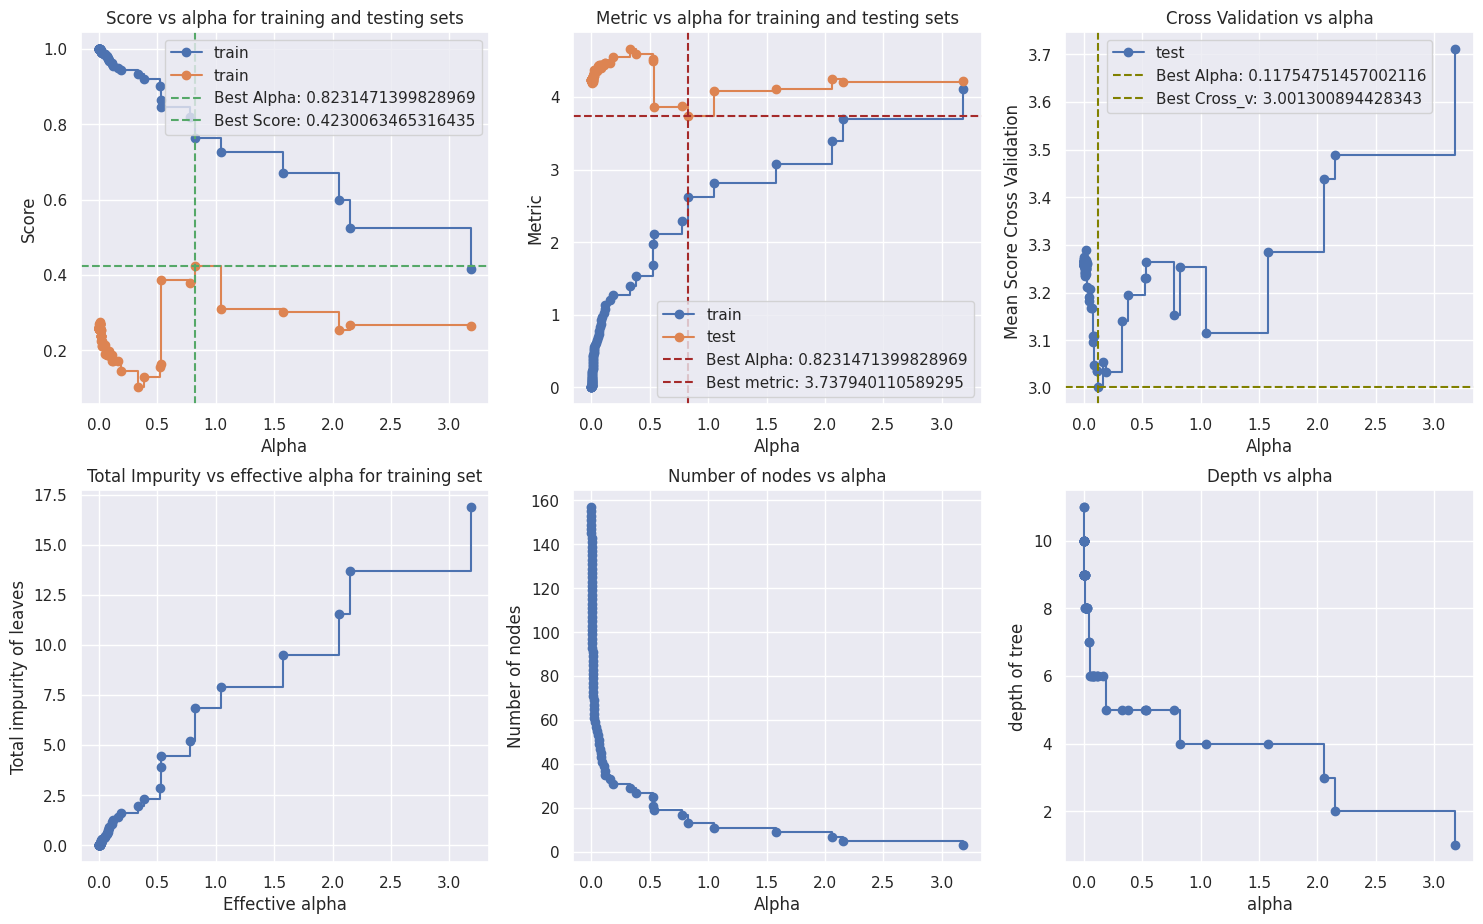

In [13]:
dta = cost_complexity_pruning_plot(
    ccp_alphas[1:-1],
    impurities[1:-1],
    node_counts[1:-1],
    depth[1:-1],
    train_scores[1:-1],
    test_scores[1:-1],
    cro_cv[1:-1],
    score_trainer[1:-1],
    score_test[1:-1],
    typ = 'R')

In [14]:
dta

,,ccp_alphas,value,impurities,nodes,depth
0,Score,0.82315,0.42301,6.87162,13,4
1,Metric,0.82315,3.73794,6.87162,13,4
2,cv-n,0.11755,3.00130,1.27420,35,6


In [15]:
model_regresion = DecisionTreeRegressor(random_state=random_seed)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)

print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 17.93586359316587 RMSE: 4.235075394035609 MAE: 3.3776401747081595


In [16]:
model_regresion = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=0.82315)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)
print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 13.972196270352313 RMSE: 3.737940110589295 MAE: 3.120486109396869


In [17]:
model_regresion = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=0.82315)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)
print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 13.972196270352313 RMSE: 3.737940110589295 MAE: 3.120486109396869


In [18]:
model_regresion = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=0.11755)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)
print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 20.026580449441035 RMSE: 4.475106752854175 MAE: 3.4835263508537393


In [19]:
X, y = make_regression(n_samples=500, n_features=8, n_informative=5, bias=0.0, noise=80, random_state=random_seed)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7
0,0.33309,0.40515,-0.29568,0.03915,0.62578,0.03084,2.14020,-2.30404
1,0.64701,0.97186,-0.25811,0.18368,-0.05451,0.66951,0.03158,0.35562
2,1.18575,-1.84027,0.01981,-0.23854,-0.56441,-1.03689,-1.20976,-1.75251
3,0.55373,0.92211,0.37396,0.66754,1.27186,-0.16641,0.60589,0.36458
4,-0.55459,-0.23257,2.49568,-0.18946,-0.29539,-1.20166,-1.05297,0.29651
...,...,...,...,...,...,...,...,...
495,-0.38648,0.78051,-0.01369,-1.73480,-1.62471,1.14644,-0.73190,0.20413
496,0.26934,1.02124,0.17559,0.91135,0.35462,-0.04796,-0.18890,-1.32060
497,0.04411,-1.40635,-2.06421,-0.57773,0.48997,-1.27363,-0.09255,0.12158
498,0.93807,0.05416,-0.80141,-2.41603,-0.46104,0.95923,-1.20203,1.72506


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_seed)

In [21]:
model_regresion = DecisionTreeRegressor(random_state=random_seed)

In [22]:
cost = model_regresion.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = cost.ccp_alphas, cost.impurities


node_counts = []
depth = []
train_scores = []
test_scores = []
models = []
cro_cv = []
score_trainer = []
score_test = []
for ccp_alpha in ccp_alphas:
  model = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=ccp_alpha)
  cro_cv.append(-1*cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())
  model.fit(X_train, y_train)
  score_trainer.append(model.score(X_train, y_train))
  score_test.append(model.score(X_test, y_test))
  node_counts.append(model.tree_.node_count)
  depth.append(model.tree_.max_depth)
  train_scores.append(mean_absolute_error(y_train, model.predict(X_train)))
  test_scores.append(mean_absolute_error(y_test, model.predict(X_test)))
  models.append(model)

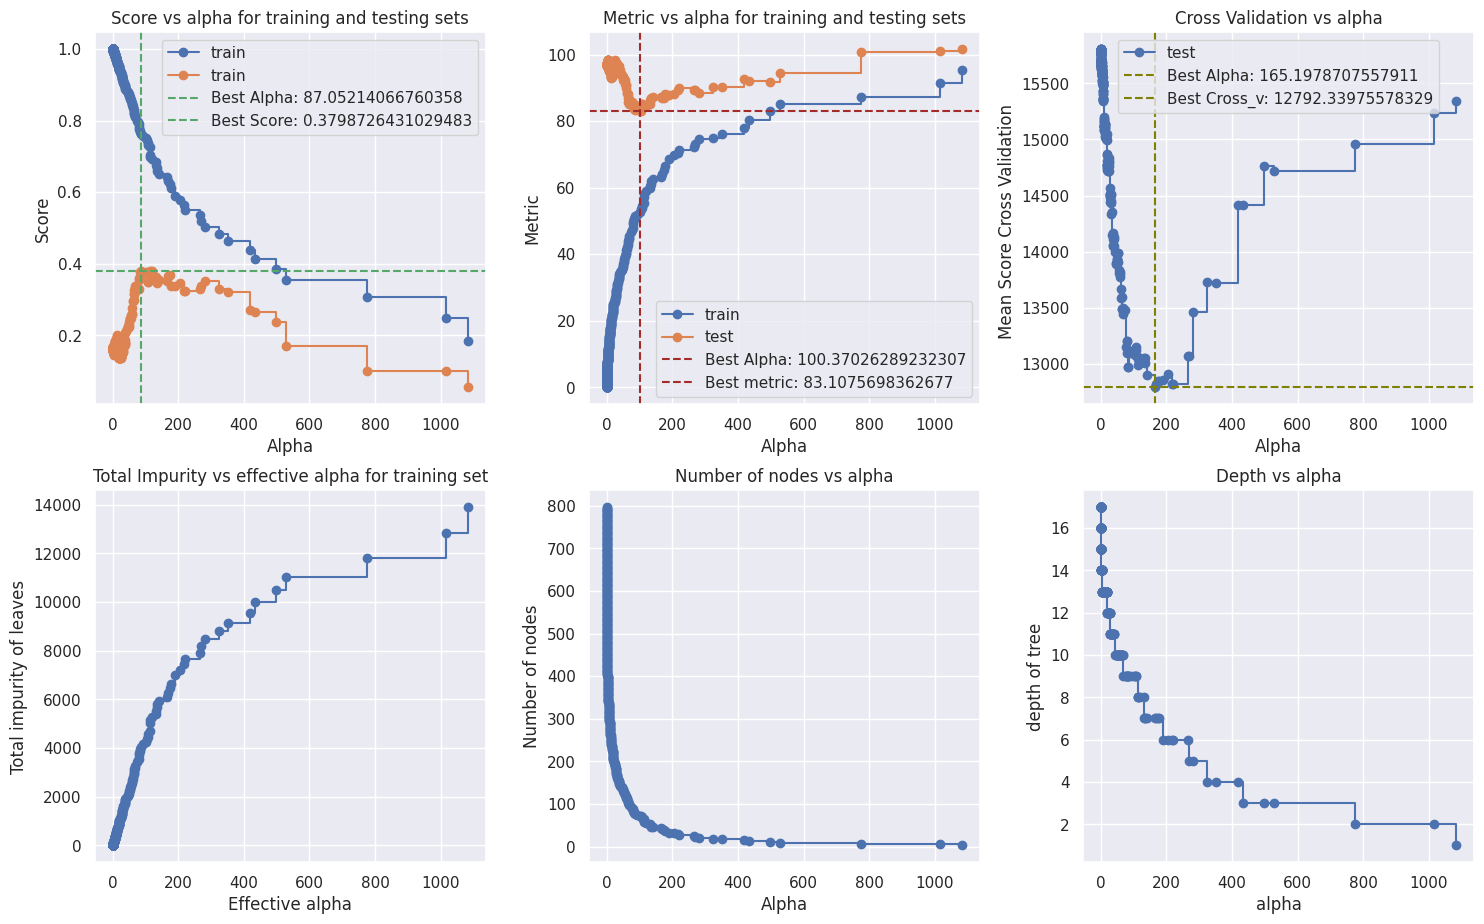

In [23]:
dta = cost_complexity_pruning_plot(
    ccp_alphas[1:-1],
    impurities[1:-1],
    node_counts[1:-1],
    depth[1:-1],
    train_scores[1:-1],
    test_scores[1:-1],
    cro_cv[1:-1],
    score_trainer[1:-1],
    score_test[1:-1],
    typ = 'R')

In [24]:
dta

,,ccp_alphas,value,impurities,nodes,depth
0,Score,87.05214,0.37987,"4,061.17243",77,9
1,Metric,100.37026,83.10757,"4,252.83419",73,9
2,cv-n,165.19787,"12,792.33976","6,111.01374",43,7


In [25]:
model_regresion = DecisionTreeRegressor(random_state=random_seed)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)

print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 14038.655053025172 RMSE: 118.48483047641656 MAE: 96.86619715602922


In [26]:
model_regresion = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=87.05214)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)
print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 10392.347421401975 RMSE: 101.94286351384277 MAE: 83.65425390857317


In [27]:
model_regresion = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=100.37026)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)
print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 10419.623487502875 RMSE: 102.07655699279279 MAE: 83.59300976208065


In [28]:
model_regresion = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=165.19787)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)
print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 10785.58299060366 RMSE: 103.8536614212694 MAE: 87.18300673037278


In [145]:
X, y = make_classification(
    n_samples=500,
    n_features=8,
    n_informative=5,
    n_redundant=0,
    random_state=random_seed,
    n_clusters_per_class=1,
    weights=[0.75, 0.25])

In [146]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7
0,0.74882,1.12289,2.31208,-0.73294,-0.14036,1.03018,-0.02160,-1.02215
1,0.85219,-0.00323,-0.02892,-1.75753,-1.15729,0.53711,-1.59152,0.97831
2,-0.69440,-1.61286,3.28771,-1.14078,1.74890,-0.53354,0.20591,1.82929
3,-0.75123,-0.61200,0.21676,-1.82523,-0.36695,-0.06770,-3.08186,0.24074
4,1.23126,-0.73644,-1.22947,0.22491,-1.88934,-0.61214,4.35592,-0.55964
...,...,...,...,...,...,...,...,...
495,-0.72297,0.30464,-0.84475,-0.70577,-3.16998,1.72960,-0.61761,0.19518
496,0.28982,-1.77327,1.05062,-1.14246,-0.67611,1.10842,-1.01170,-1.16813
497,1.58234,1.85882,0.38088,-1.88776,-0.09206,-0.07244,-3.47476,-0.47081
498,-1.54364,0.88997,2.78619,-3.28042,-0.28944,-4.22166,-0.14087,-0.22391


In [147]:
model_clasification = DecisionTreeClassifier(random_state=random_seed)

In [148]:
pd.Series(y).value_counts()

,count
0,374
1,126


In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.65, random_state=random_seed, stratify=y)

In [153]:
cost = model_regresion.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = cost.ccp_alphas, cost.impurities


node_counts = []
depth = []
train_scores = []
test_scores = []
models = []
cro_cv = []
score_trainer = []
score_test = []
for ccp_alpha in ccp_alphas:
  model = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=ccp_alpha)
  cro_cv.append(cross_val_score(model, X_train, y_train, cv=5, scoring='precision').mean())
  model.fit(X_train, y_train)
  score_trainer.append(model.score(X_train, y_train))
  score_test.append(model.score(X_test, y_test))
  node_counts.append(model.tree_.node_count)
  depth.append(model.tree_.max_depth)
  train_scores.append(recall_score(y_train, model.predict(X_train)))
  test_scores.append(recall_score(y_test, model.predict(X_test)))
  models.append(model)

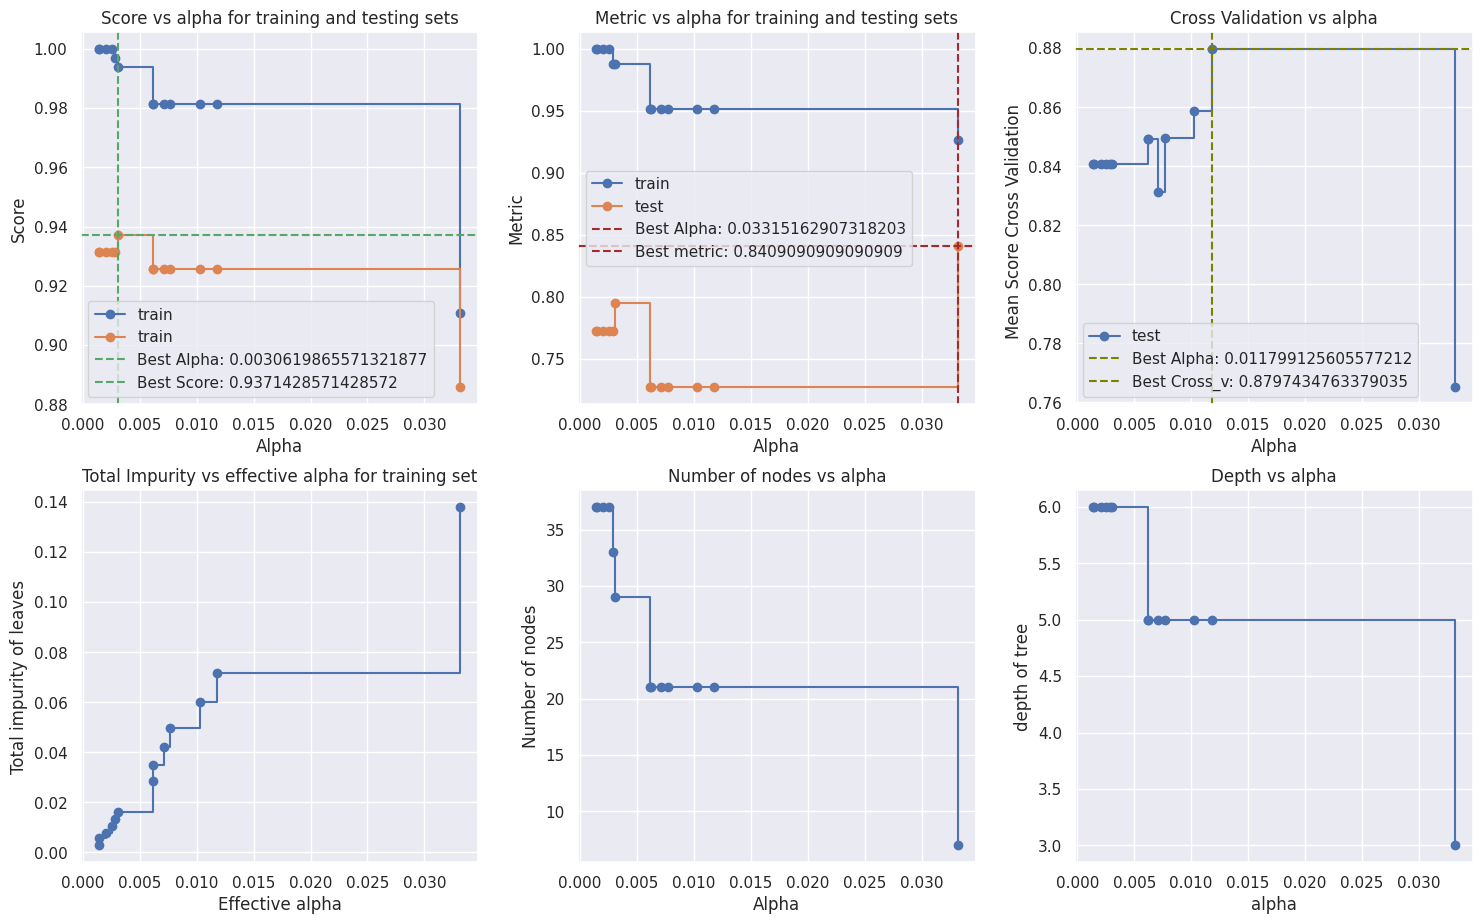

In [154]:
dta = cost_complexity_pruning_plot(
    ccp_alphas[1:-1],
    impurities[1:-1],
    node_counts[1:-1],
    depth[1:-1],
    train_scores[1:-1],
    test_scores[1:-1],
    cro_cv[1:-1],
    score_trainer[1:-1],
    score_test[1:-1],
    typ = 'C')

In [155]:
dta

,,ccp_alphas,value,impurities,nodes,depth
0,Score,0.00306,0.93714,0.01630,29,6
1,Metric,0.03315,0.84091,0.13802,7,3
2,cv-n,0.01180,0.87974,0.07172,21,5


In [162]:
model_clasification = DecisionTreeClassifier(random_state=random_seed)

model_clasification.fit(X_train, y_train)
y_predict = model_clasification.predict(X_test)

print(
    f'Precision: {precision_score(y_test, y_predict)}',
    f'Recall: {recall_score(y_test, y_predict)}'
)

Precision: 0.9444444444444444 Recall: 0.7727272727272727


In [163]:
model_clasification = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=0.00306)

model_clasification.fit(X_train, y_train)
y_predict = model_clasification.predict(X_test)

print(
    f'Precision: {precision_score(y_test, y_predict)}',
    f'Recall: {recall_score(y_test, y_predict)}'
)

Precision: 0.9459459459459459 Recall: 0.7954545454545454


In [164]:
model_clasification = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=0.03315)

model_clasification.fit(X_train, y_train)
y_predict = model_clasification.predict(X_test)

print(
    f'Precision: {precision_score(y_test, y_predict)}',
    f'Recall: {recall_score(y_test, y_predict)}'
)

Precision: 0.74 Recall: 0.8409090909090909


In [165]:
model_clasification = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=0.01180)

model_clasification.fit(X_train, y_train)
y_predict = model_clasification.predict(X_test)

print(
    f'Precision: {precision_score(y_test, y_predict)}',
    f'Recall: {recall_score(y_test, y_predict)}'
)

Precision: 0.9696969696969697 Recall: 0.7272727272727273
